In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import re
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('/content/drive/MyDrive/23-2 창의적종합설계 /LSTM/231205/eco_merged_f.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled,pax_prob_scaled
0,2023-02-01,123500,129500,123500,128400,569539,0.045603,0.720895,0.588008,0.500000
1,2023-02-02,130500,132000,129400,131000,451433,0.020249,0.719629,0.592710,0.500000
2,2023-02-03,130800,142200,129100,137600,1194656,0.050382,0.744021,0.582911,0.500000
3,2023-02-06,138500,149000,138200,146200,1350414,0.062500,0.709026,0.624390,0.500000
4,2023-02-07,147200,178100,147000,165900,3892423,0.134747,0.716227,0.557894,0.268041


### 전처리 및 Window Dataset

In [6]:
df.drop('Date', axis=1, inplace=True)
df

,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled,pax_prob_scaled
0,123500,129500,123500,128400,569539,0.045603,0.720895,0.588008,0.500000
1,130500,132000,129400,131000,451433,0.020249,0.719629,0.592710,0.500000
2,130800,142200,129100,137600,1194656,0.050382,0.744021,0.582911,0.500000
3,138500,149000,138200,146200,1350414,0.062500,0.709026,0.624390,0.500000
4,147200,178100,147000,165900,3892423,0.134747,0.716227,0.557894,0.268041
...,...,...,...,...,...,...,...,...,...
119,1148000,1321000,1120000,1293000,2074447,0.113695,0.724845,0.601424,0.246811
120,1303000,1539000,1136000,1228000,3016645,-0.050271,0.733201,0.581307,0.370817
121,1200000,1200000,961000,985000,2847371,-0.197883,0.723892,0.579328,0.329509
122,956000,1111000,935000,1104000,2058139,0.120812,0.747329,0.596435,0.283428


In [216]:
df.drop('news_prob_scaled', axis=1, inplace=True)

In [217]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change',
       'jongto_prob_scaled'],
      dtype='object')

In [218]:
y = df["Close"]
x = df.drop("Close",axis=1)

In [219]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

In [220]:
train = pd.concat([x_train,y_train], axis=1)
test = pd.concat([x_test,y_test], axis=1)

In [221]:
train = pd.concat([x_train,y_train], axis=1)
test = pd.concat([x_test,y_test], axis=1)

In [222]:
sc = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']


train[scale_cols] = sc.fit_transform(train[scale_cols])
test[scale_cols] = sc.transform(test[scale_cols])

In [223]:
# many2many -> outpu_window size = 1로 함수 수정
def windowDataset(df, window_size, batch_size, shuffle) :
    x = df.drop("Close",axis=1)
    y = df["Close"]
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, stride = 1, shift = 1, drop_remainder = True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices([y[i:i+1].values for i in range(window_size, len(y)-1)])

    data = tf.data.Dataset.zip((ds_x,ds_y))

    #if shuffle :
        #data = data.shuffle(10)

    return data.batch(batch_size).prefetch(1)

In [224]:
WINDOW_SIZE = 3
BATCH_SIZE=1
ratio = int(len(train) * 0.8)

train_data = windowDataset(train[:ratio], WINDOW_SIZE, BATCH_SIZE, shuffle= True)
val_data = windowDataset(train[ratio:], WINDOW_SIZE, BATCH_SIZE, shuffle = False)
test_data = windowDataset(test, WINDOW_SIZE, BATCH_SIZE, shuffle = False)

In [225]:
for data in train_data.take(1):
    print(f'학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): (1, 3, 6)
학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): (1, 1)


In [226]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [227]:
len(test)

25

### LSTM

In [276]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="elu",
           input_shape=[None, 6]),
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.3),

    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),

    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.5),

    Dense(32, activation="relu"),
    Dropout(0.3),

    Dense(16, activation="relu"),
    Dropout(0.4),

    Dense(1),
])


In [277]:
loss = Huber()
optimizer = Adam(0.00005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [278]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [279]:
history = model.fit(train_data,
                    validation_data=(val_data),
                    epochs=100,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     73/Unknown - 8s 10ms/step - loss: 0.1577 - mse: 0.3154
Epoch 1: val_loss improved from inf to 0.37681, saving model to tmp/ckeckpointer.ckpt
75/75 [==============================] - 9s 20ms/step - loss: 0.1595 - mse: 0.3190 - val_loss: 0.3768 - val_mse: 0.7536
Epoch 2/100
74/75 [============================>.] - ETA: 0s - loss: 0.1527 - mse: 0.3054
Epoch 2: val_loss improved from 0.37681 to 0.36621, saving model to tmp/ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 0.1535 - mse: 0.3070 - val_loss: 0.3662 - val_mse: 0.7324
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.1487 - mse: 0.2974
Epoch 3: val_loss improved from 0.36621 to 0.35568, saving model to tmp/ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 0.1487 - mse: 0.2974 - val_loss: 0.3557 - val_mse: 0.7114
Epoch 4/100
71/75 [===========================>..] - ETA: 0s - loss: 0.1375 - mse: 0.2750
Epoch 4: val_loss improved from 

In [280]:
model.load_weights(filename)

In [281]:
pred = model.predict(test_data)

21/21 [==============================] - 1s 5ms/step


In [282]:
pred.shape

(21, 1)

In [283]:
pred

array([[0.71333504],
       [0.6992391 ],
       [0.7018623 ],
       [0.77413803],
       [0.90058297],
       [0.9722576 ],
       [1.0022825 ],
       [1.0407403 ],
       [1.0576377 ],
       [1.0811082 ],
       [1.0503422 ],
       [1.0289267 ],
       [1.0362253 ],
       [1.097198  ],
       [1.1822001 ],
       [1.2840724 ],
       [1.3115573 ],
       [1.3076433 ],
       [1.3795261 ],
       [1.542049  ],
       [1.689435  ]], dtype=float32)

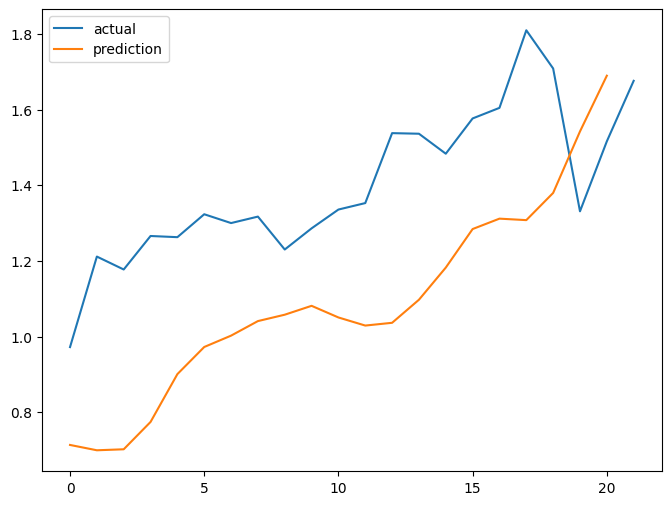

In [284]:
plt.figure(figsize=(8, 6))
plt.plot(np.asarray(test['Close'])[3:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

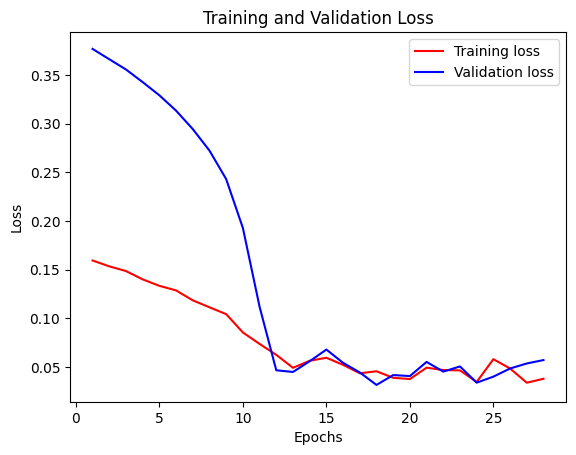

In [285]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [286]:
score = model.evaluate(test_data)
score

21/21 [==============================] - 0s 5ms/step - loss: 0.0622 - mse: 0.1245


[0.0622420497238636, 0.1244840994477272]